<a href="https://colab.research.google.com/github/irenetsk/mastersthesis/blob/main/1_1_LABPROP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Label Propagation Classification (semi-supervised)
https://scikit-learn.org/stable/modules/generated/sklearn.semi_supervised.LabelPropagation.html

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/My Drive/
import numpy as np
from sklearn.model_selection import train_test_split
from collections import Counter
import sklearn.metrics as metrics
from sklearn.semi_supervised import LabelPropagation
import random
! pip install --upgrade tbb
! pip install umap-learn
import umap
! pip install -U sentence-transformers
from sentence_transformers import SentenceTransformer

Mounted at /content/drive
/content/drive/My Drive
     |████████████████████████████████| 4.0 MB 4.9 MB/s 
     |████████████████████████████████| 88 kB 3.1 MB/s 
     |████████████████████████████████| 1.1 MB 44.7 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=452acc5d71e65f911be1f9f8f867e3d3b8ba6f2032fa1584205e575ee463e5f3
  Stored in directory: /root/.cache/pip/wheels/b3/52/a5/1fd9e3e76a7ab34f134c07469cd6f16e27ef3a37aeff1fe821
  Created wheel for pynndescent: filename=pynndescent-0.5.6-py3-none-any.whl size=53943 sha256=ef2c89920f8b505b7cd622cc69c1aa03e4b4eb0f0dbe90034483e8510bf32468
  Stored in directory: /root/.cache/pip/wheels/03/f1/56/f80d72741e400345b5a5b50ec3d929aca581bf45e0225d5c50
Successfully built umap-learn pynndescent
     |████████████████████████████████| 79 kB 3.9 MB/s 
     |████████████████████████████████| 4.0 MB 12.9 MB/s 
     |████████████████████████████████| 1.2 MB 51.8 MB/s 
     |███████████████████████████

## Fine-grained (4 classes)

### Dataset & SBERT
1 = Enthusiastic / 2 = Neutral / 3 = Sad / 4 = Angry


In [21]:
# READSPEAKER SENTENCES
angrysents = []
with open("./thesis/readspeaker_annots/emotion_02_anger.txt", encoding='utf-8') as f:
  f = (f.read()).split("\n")
  for sent in f:
    angrysents.append(sent)
# angrysents = list(set(angrysents))                                # to ensure the deletion of duplicates
angrylabels = ['4' for i in range(len(angrysents))]

enthusents = []
with open("./thesis/readspeaker_annots/emotion_03_happy.txt", encoding='utf-8') as f:
  f = (f.read()).split("\n")
  for sent in f:
    enthusents.append(sent)
# enthusents = list(set(enthusents))
enthulabels = ['1' for i in range(len(enthusents))]

sadsents = []
with open("./thesis/readspeaker_annots/emotion_04_sadness.txt", encoding='utf-8') as f:
  f = (f.read()).split("\n")
  for sent in f:
    sadsents.append(sent)
# sadsents = list(set(sadsents))
sadlabels = ['3' for i in range(len(sadsents))]

# MY ANNOTATIONS
trainsents = []
with open("./thesis/myannotations/sents.txt", encoding='utf-8') as f:
  f = (f.read()).split("\n")
  for sent in f:
    trainsents.append(sent)

trainlabels = []
with open("./thesis/myannotations/labels.txt", encoding='utf-8') as f:
  f = (f.read()).split("\n")
  for label in f:
    trainlabels.append(label)

with open("./thesis/myannotations/moreneutral_sents.txt", encoding='utf-8') as f:
  f = (f.read()).split("\n")
  for sent in f:
    trainsents.append(sent)
  for i in range(len(f)):
    trainlabels.append('2')

rs_sents = angrysents + enthusents + sadsents
rs_labels = angrylabels + enthulabels + sadlabels
combinedsents = trainsents + rs_sents
combinedlabels = trainlabels + rs_labels

In [3]:
print(f'enthusiastic: \t{len(enthusents)} \nsad: \t\t{len(sadsents)}\nangry: \t\t{len(angrysents)}\nmy annotations: {len(trainsents)}\ntotal: \t\t{sum([len(angrysents), len(enthusents), len(sadsents), len(trainsents)])}')

enthusiastic: 	650 
sad: 		638
angry: 		601
my annotations: 704
total: 		2593


In [22]:
# sent2idx = dict()
X_lab, X_unlab = [],[]
y_lab, y_unlab = [],[]

with open("thesis/corpora/eng-simple_wikipedia_2021_10K-sentences.txt", encoding='utf-8') as f1:
  f1 = (f1.read()).split("\n")
  with open("thesis/corpora/eng-uk_web-public_2018_10K-sentences.txt", encoding='utf-8') as f2:
    f2 = (f2.read()).split("\n")
    for i, line in enumerate(f1+f2):
        sent = (line[(len(str(i+1))):]).strip()                                     # removes the line number and the tab char
        if sent in trainsents:
          # sent2idx[sent] = i                                                      # to find them in the embedding
          X_lab.append(sent)
          y_lab.append(int(combinedlabels[combinedsents.index(sent)]))
        else:
          X_unlab.append(sent)
          y_unlab.append(-1)

# track = len(unlabeled+labeled)
for i, sent in enumerate(rs_sents):
  X_lab.append(sent)
  y_lab.append(int(combinedlabels[combinedsents.index(sent)]))
  # sent2idx[sent] = track + i

In [23]:
X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(X_lab, y_lab, random_state=42, train_size=0.7)

In [57]:
X_train_temp = X_train_split + X_unlab
y_train_temp = y_train_split + y_unlab
X_test_temp = X_test_split
y_test = y_test_split

sbert = SentenceTransformer('paraphrase-MiniLM-L3-v2')                  # https://www.sbert.net/docs/pretrained_models.html
X_ENC = sbert.encode(X_train_temp)
X_test = sbert.encode(X_test_temp)

[:21113] -> 20000 unlab (real number is 19,298)

[:11815] -> 10000 unlab

[:6815] -> 5000 unlab

[:4815] -> 3000 unlab

[:3630] -> 1815 unlab (1:1)

[:2815] -> 1000 unlab

[:2565] -> 750 unlab

[:2315] -> 500 unlab

[:2215] -> 400 unlab.   

[:2115] -> 300 unlab

[:2015] -> 200 unlab

[:1815] -> 0 unlab

In [69]:
X_train = X_ENC[:11815]      # [:2315] -> 500 unlab  [:2265] -> 450 unlab [:2215] -> 400 unlab.   [:2115] -> 300 unlab
y_train = y_train_temp[:11815]

In [8]:
# print(dict(Counter(list(y_train))))
# print(dict(Counter(list(y_test))))

### Model

* triangle of inequality breached?
* cos sim not a proper metric although natural for this case



In [70]:
from sklearn import metrics

## function tweaked from https://stackoverflow.com/questions/52057836/labelpropagation-how-to-avoid-division-by-zero
def custom_rbf(X, Y=None, gamma=14):
      K = (1 - metrics.pairwise.cosine_similarity(X, Y))**2
      K *= -gamma 
      np.exp(K, K)
      return K

# model = LabelPropagation(kernel = 'rbf', gamma = 0.005, max_iter = 500)
model = LabelPropagation(kernel = custom_rbf, tol = 0.1)   
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
sc = model.score(X_test, y_test)
print(sc)
print(model.n_iter_)

0.6799485861182519
171


*   run best parameters (10k unlab + gamma =14 with custom rbf) and visualize
*   do all separate classes
*   label spreading with **custom rbf** and **og rbf**



In [10]:
# best_hyperparameters = None
# grid = {'kernel': ['rbf'],
#         'gamma': [1, 5, 10, 25, 50],
#       #  'gamma': [0.5, 0.2, 1.0, 0.1, 0.8],
#         'max_iter': [100, 300, 600]}
# print("kernel:\t\tgamma:\t\tmax_iter:\t\tTraining set accuracy:")

# for i in range(20):
#   kn = grid['kernel'][0]
#   gm = grid['gamma'][random.randint(0,4)]
#   maxit = grid['max_iter'][random.randint(0,2)]
  
#   model = LabelPropagation(kernel = kn, gamma = gm, max_iter=maxit)
#   model.fit(X_train, y_train)
#   # y_pred = model.predict(X_test)
#   training_accuracy = model.score(X_test, y_test)
#   if best_hyperparameters is None or best_hyperparameters[3] < training_accuracy:
#     best_hyperparameters = (kn, gm, maxit, training_accuracy)
#   print(f"{kn}\t\t{gm}\t\t{maxit}\t\t{training_accuracy}")

# best_kernel = best_hyperparameters[0]
# best_gamma = best_hyperparameters[1]
# best_maxit = best_hyperparameters[2]
# best_score = best_hyperparameters[3]

# print(f"Best parameters:{best_kernel}\t{best_gamma}\t{best_maxit}\t{best_score}")

### Visualizations

#### from https://scikit-learn.org/stable/auto_examples/semi_supervised/plot_label_propagation_structure.html

In [62]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1])

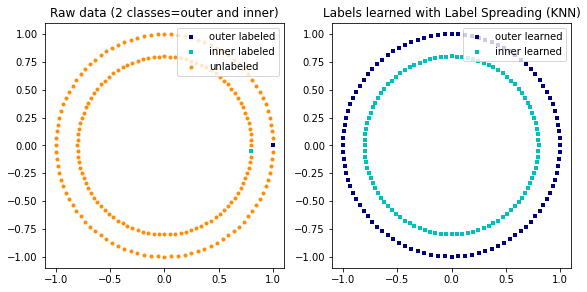

In [59]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.semi_supervised import LabelSpreading
from sklearn.datasets import make_circles

# generate ring with inner box
n_samples = 200
X, y = make_circles(n_samples=n_samples, shuffle=False)
outer, inner = 0, 1
labels = np.full(n_samples, -1.0)
labels[0] = outer
labels[-1] = inner

# #############################################################################
# Learn with LabelSpreading
label_spread = LabelSpreading(kernel="knn", alpha=0.8)
label_spread.fit(X, labels)

# #############################################################################
# Plot output labels
output_labels = label_spread.transduction_
plt.figure(figsize=(8.5, 4))
plt.subplot(1, 2, 1)
plt.scatter(
    X[labels == outer, 0],
    X[labels == outer, 1],
    color="navy",
    marker="s",
    lw=0,
    label="outer labeled",
    s=10,
)
plt.scatter(
    X[labels == inner, 0],
    X[labels == inner, 1],
    color="c",
    marker="s",
    lw=0,
    label="inner labeled",
    s=10,
)
plt.scatter(
    X[labels == -1, 0],
    X[labels == -1, 1],
    color="darkorange",
    marker=".",
    label="unlabeled",
)
plt.legend(scatterpoints=1, shadow=False, loc="upper right")
plt.title("Raw data (2 classes=outer and inner)")

plt.subplot(1, 2, 2)
output_label_array = np.asarray(output_labels)
outer_numbers = np.where(output_label_array == outer)[0]
inner_numbers = np.where(output_label_array == inner)[0]
plt.scatter(
    X[outer_numbers, 0],
    X[outer_numbers, 1],
    color="navy",
    marker="s",
    lw=0,
    s=10,
    label="outer learned",
)
plt.scatter(
    X[inner_numbers, 0],
    X[inner_numbers, 1],
    color="c",
    marker="s",
    lw=0,
    s=10,
    label="inner learned",
)
plt.legend(scatterpoints=1, shadow=False, loc="upper right")
plt.title("Labels learned with Label Spreading (KNN)")

plt.subplots_adjust(left=0.07, bottom=0.07, right=0.93, top=0.92)
plt.show()

#### Distance Matrix

In [12]:
X_test.shape

(778, 384)

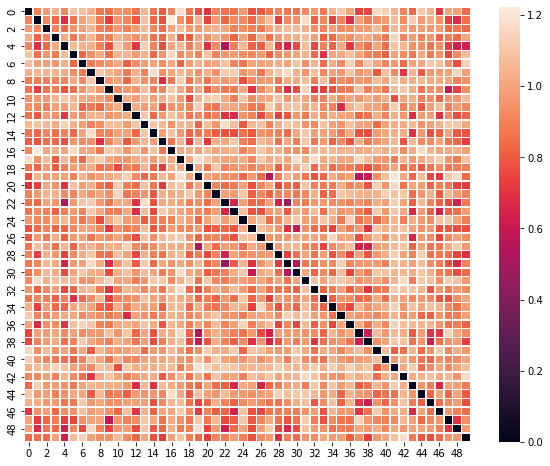

In [13]:
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
from matplotlib.pyplot import figure
from scipy.spatial import distance_matrix

plt.figure(figsize=(10,8))
from sklearn.metrics.pairwise import cosine_similarity
data = 1 - cosine_similarity(X_test[50:100], X_test[50:100])
ax = sns.heatmap(data, linewidth=0.5)
plt.show()

In [14]:
# from sklearn.neighbors import KNeighborsClassifier
# from scipy.spatial.distance import cosine
# neigh = KNeighborsClassifier(weights='distance', algorithm='auto', metric = cosine)
# neigh.fit(X_train[np.asarray(y_train)>-1], np.asarray(y_train)[np.asarray(y_train)>-1])
# y_pred = neigh.predict(X_test)
# print(neigh.score(X_test, y_test))

#### UMAP & Plot

In [71]:
reducer = umap.UMAP(n_components=3)
embedding = reducer.fit_transform(X_test)

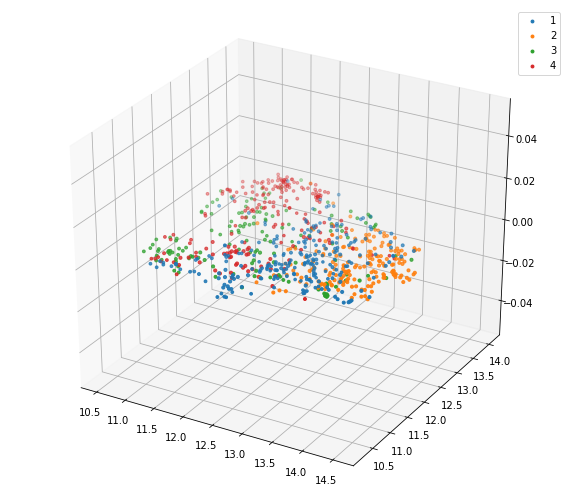

In [72]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

u_labels = np.unique(y_pred)
fig = plt.figure(figsize=(10,9))
ax = plt.axes(projection='3d')

for i in u_labels:
    plt.scatter(embedding[y_pred == i , 0], embedding[y_pred == i , 1], embedding[y_pred == i , 2],  label = i)
    # plt.scatter(X_test[y_pred == i , 0], X_test[y_pred == i , 1], X_test[y_pred == i , 2],  label = i)
plt.legend()
plt.show()

# VARIATIONS IN NUMBER OF CLASSES

## 3 classes (RS data) UNDER CONSTRUCTION

In [17]:
# READSPEAKER SENTENCES
angrysents = []
with open("./thesis/readspeaker_annots/emotion_02_anger.txt", encoding='utf-8') as f:
  f = (f.read()).split("\n")
  for sent in f:
    angrysents.append(sent)
angrylabels = ['4' for i in range(len(angrysents))]

enthusents = []
with open("./thesis/readspeaker_annots/emotion_03_happy.txt", encoding='utf-8') as f:
  f = (f.read()).split("\n")
  for sent in f:
    enthusents.append(sent)
enthulabels = ['1' for i in range(len(enthusents))]

sadsents = []
with open("./thesis/readspeaker_annots/emotion_04_sadness.txt", encoding='utf-8') as f:
  f = (f.read()).split("\n")
  for sent in f:
    sadsents.append(sent)
sadlabels = ['3' for i in range(len(sadsents))]

rs_sents = angrysents + enthusents + sadsents
rs_labels = angrylabels + enthulabels + sadlabels

In [18]:
X_lab, X_unlab = [],[]
y_lab, y_unlab = [],[]

with open("thesis/corpora/eng-simple_wikipedia_2021_10K-sentences.txt", encoding='utf-8') as f1:
  f1 = (f1.read()).split("\n")
  with open("thesis/corpora/eng-uk_web-public_2018_10K-sentences.txt", encoding='utf-8') as f2:
    f2 = (f2.read()).split("\n")
    for i, line in enumerate(f1+f2):
        sent = (line[(len(str(i+1))):]).strip()                                     # removes the line number and the tab char
        if sent in trainsents:
          X_lab.append(sent)
          y_lab.append(combinedlabels[combinedsents.index(sent)])
        else:
          X_unlab.append(sent)
          y_unlab.append(-1)

for i, sent in enumerate(rs_sents):
  X_lab.append(sent)
  y_lab.append(combinedlabels[combinedsents.index(sent)])


In [19]:
X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(X_lab, y_lab, random_state=42, train_size=0.7)

X_train_temp = X_train_split + X_unlab[:1815]
y_train = [int(label) for label in y_train_split + y_unlab[:1815]]
X_test_temp = X_test_split
y_test = [int(label) for label in y_test_split]

sbert = SentenceTransformer('paraphrase-MiniLM-L6-v2')
X_train = sbert.encode(X_train_temp)
X_test = sbert.encode(X_test_temp)

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.69k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/314 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

KeyboardInterrupt: ignored

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, random_state=42, train_size=0.7)
neigh = KNeighborsClassifier(weights='distance', algorithm='auto', metric=cosine)      # weights='distance', algorithm='auto'
neigh.fit(X_train, y_train)
y_pred = neigh.predict(X_test)
print(neigh.score(X_test, y_test))

## 3 classes positive-neutral-negative (RS data+neutralsents)

## Binary classification (2 classes)

## Binary classification (2 classes) (comb happy+neut & ang+sad)

# BEST RESULTS

| Algorithm | kernel | gamma | no of unlabeled sents | score |
|-|-|-|-|-|
|Label Prop|custom rbf|14|10,000|**67,994**|
|Label Spreading|rbf|0.3|-|**0.6619537275064268**|

have sth like this on my thesis https://scikit-learn.org/stable/_images/sphx_glr_plot_label_propagation_structure_001.png found on https://scikit-learn.org/stable/modules/semi_supervised.html#label-propagation